In [5]:
import os
import glob
import cv2
import numpy as np
import autoencoder
import umap
import matplotlib.pyplot as plt


import matplotlib.cm as cm
import matplotlib.colors as mcolors


import torch
from torch import nn, optim
from PIL import Image
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [6]:

# Function to read images and save/load them in .npz format
def read_images(root_dir, sub_dir):
    npz_file = f'{root_dir}_{sub_dir}.npz'
    if not os.path.exists(npz_file):
        img_list = []
        label_list = []
        img_path_list = glob.glob(os.path.join(root_dir, sub_dir, '*'))

        for pth in img_path_list:
            # Read image and flatten to a vector
            img = cv2.imread(pth, 0)
            img_flat = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA).flatten()
            img_list.append(img_flat)

            # Extract class label from the file name
            c_num = int(os.path.basename(pth).split('_')[0])
            label_list.append(c_num)

        # Save images and labels to .npz format
        np.savez_compressed(npz_file, x=np.array(img_list), y=np.array(label_list))

    # Load the data from .npz file
    data = np.load(npz_file, allow_pickle=True)
    return data['x'], data['y']

# Function to normalize the data
def normalize(x):
    return x / np.expand_dims(np.linalg.norm(x, axis=1), axis=1)


def calcLDA(x, y, p):

    # Number of classes and samples
    num_classes = np.max(y)  # Assumes y contains 1-based class indices
    num_samples, num_features = x.shape
    
    # Initialize variables
    class_counts = np.bincount(y, minlength=num_classes + 1)[1:]  # [1:] to skip class 0
    class_means = np.zeros((num_classes, num_features))
    
    # Compute per-class means
    for label in range(1, num_classes + 1):
        class_samples = x[y == label]
        class_means[label - 1] = np.mean(class_samples, axis=0)
    
    # Global mean of the data
    global_mean = np.mean(x, axis=0)
    x_centered = x - global_mean

    # Compute scatter between classes (Sb)
    m_i = class_means - global_mean  # Shape: (num_classes, num_features)
    Sb = m_i.T @ np.diag(class_counts) @ m_i  # Shape: (num_features, num_features)

    # Compute scatter within classes (Sw)
    Sw = np.zeros((num_features, num_features))
    for label in range(1, num_classes + 1):
        class_samples = x[y == label]
        centered_samples = class_samples - class_means[label - 1]
        Sw += centered_samples.T @ centered_samples  # Accumulate class-wise scatter

    # Solve the generalized eigenvalue problem for LDA
    eigvals, eigvecs = np.linalg.eigh(np.linalg.pinv(Sw) @ Sb)

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]

    # Select the top p eigenvectors
    W = eigvecs[:, :p]  # Shape: (num_features, p)

    return W, global_mean


def calcPCA(x, p=None):
    # Transpose data to have samples as rows and features as columns
    x = np.transpose(x)
    # Calculate the mean of the data
    m = np.mean(x, axis=1, keepdims=True)
    # Center the data
    X = x - m
    # Calculate the covariance matrix
    cov = np.dot(X.T, X)
    # Perform singular value decomposition on the covariance matrix
    _, _, ut = np.linalg.svd(cov)
    # Multiply the eigenvectors of X'X by X to get the eigenvectors of XX'
    w = np.dot(X, ut.T)
    # Normalize the eigenvectors
    w = normalize(w)  # Assuming you have a normalization function defined
    # Retain the first p principal components
    if p is not None:
        w_p = w[:, :p]
    else:
        w_p = w

    return w_p, m



def plot_umap(y_train, PCA_train_2D, PCA_test_2D, LDA_train_2D, 
              LDA_test_2D, pred_test_pca, pred_test_lda, p):
    # Define a colormap for 30 classes
    cmap = cm.get_cmap('tab20', 30)  # 'tab20' supports up to 20 distinct colors; use others like 'viridis' for continuous
    norm = mcolors.Normalize(vmin=1, vmax=30)  # Normalize class labels to [1, 30] range
    
    # Plot PCA results with colorbar
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(
        PCA_train_2D[:, 0],
        PCA_train_2D[:, 1],
        c=y_train + 1,  # Shift labels to start from 1
        cmap=cmap,
        norm=norm,
        alpha=0.6
    )
    plt.title(f"PCA (Train) with p = {p}")
    cbar = plt.colorbar(scatter)
    cbar.set_label("Class Label")
    cbar.set_ticks(range(1, 31))  # Ensure ticks align with classes starting from 1

    plt.subplot(1, 2, 2)
    scatter = plt.scatter(
        PCA_test_2D[:, 0],
        PCA_test_2D[:, 1],
        c=pred_test_pca + 1,  # Shift labels to start from 1
        cmap=cmap,
        norm=norm,
        alpha=0.6
    )
    plt.title(f"PCA (Test) with Predicted Labels (p = {p})")
    cbar = plt.colorbar(scatter)
    cbar.set_label("Class Label")
    cbar.set_ticks(range(1, 31))  # Ensure ticks align with classes starting from 1
    plt.savefig(f"PCA_results_p_{p}.png")
    
    # Plot LDA results with colorbar
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(
        LDA_train_2D[:, 0],
        LDA_train_2D[:, 1],
        c=y_train + 1,  # Shift labels to start from 1
        cmap=cmap,
        norm=norm,
        alpha=0.6
    )
    plt.title(f"LDA (Train) with p = {p}")
    cbar = plt.colorbar(scatter)
    cbar.set_label("Class Label")
    cbar.set_ticks(range(1, 31))  # Ensure ticks align with classes starting from 1
    
    plt.subplot(1, 2, 2)
    scatter = plt.scatter(
        LDA_test_2D[:, 0],
        LDA_test_2D[:, 1],
        c=pred_test_lda + 1,  # Shift labels to start from 1
        cmap=cmap,
        norm=norm,
        alpha=0.6
    )
    plt.title(f"LDA (Test) with Predicted Labels (p = {p})")
    cbar = plt.colorbar(scatter)
    cbar.set_label("Class Label")
    cbar.set_ticks(range(1, 31))  # Ensure ticks align with classes starting from 1
    plt.savefig(f"LDA_results_p_{p}.png")



# 1-NN classifier
def one_nn(ft_space, p_x_test, y_train):
    # Calculate squared Euclidean distance
    dist = np.sum((ft_space - p_x_test[:, np.newaxis]) ** 2, axis=0)

    # Find the label of the nearest neighbor
    pred_label = y_train[np.argmin(dist)]
    return pred_label

def classifier(x_train, x_test, y_train, y_test, p):
    # Calculate principal components and linear discriminants
    W_p_PCA, m = calcPCA(x_train, p)
    W_p_LDA, _ = calcLDA(x_train, y_train, p)

    # Transpose data for matrix operations
    x_train_centered = x_train.T - m
    x_test_centered = x_test.T - m

    # Project training data onto respective subspaces
    PCA_space = np.dot(W_p_PCA.T, x_train_centered)
    LDA_space = np.dot(W_p_LDA.T, x_train_centered)

    # Project all test data in one step
    PCA_test_space = np.dot(W_p_PCA.T, x_test_centered)
    LDA_test_space = np.dot(W_p_LDA.T, x_test_centered)



    # Classify using nearest neighbor
    pred_lbls_PCA = np.array([one_nn(PCA_space, PCA_test_space[:, i], y_train) for i in range(PCA_test_space.shape[1])])
    pred_lbls_LDA = np.array([one_nn(LDA_space, LDA_test_space[:, i], y_train) for i in range(LDA_test_space.shape[1])])

    # Apply UMAP to reduce PCA and LDA embeddings to 2D
    umap_model = umap.UMAP(n_components=2)
    PCA_train_2D = umap_model.fit_transform(PCA_space.T)
    PCA_test_2D = umap_model.transform(PCA_test_space.T)

    LDA_train_2D = umap_model.fit_transform(LDA_space.T)
    LDA_test_2D = umap_model.transform(LDA_test_space.T)
    if p in plot_ump_p_list:
        plot_umap(y_train, PCA_train_2D, PCA_test_2D, LDA_train_2D, 
                LDA_test_2D, pred_lbls_PCA, pred_lbls_LDA, p)



    # Calculate classification accuracy
    # print(pred_lbls_PCA)
    accuracy_PCA = np.mean(pred_lbls_PCA == y_test) * 100
    accuracy_LDA = np.mean(pred_lbls_LDA == y_test) * 100
    
    # Add lda acc
    return accuracy_PCA, accuracy_LDA

def autoenc_classifier(X_train, Y_train, X_test, Y_test):
  pred_lbls = []

  num_test_samples = len(Y_test)

  for i in range(num_test_samples):
    pred = one_nn(np.transpose(X_train), X_test[i], Y_train)
    pred_lbls.append(pred)

  accuracy = np.mean(np.equal(np.array(pred_lbls), Y_test)) * 100
  return accuracy

In [7]:

# def plot_umap_embeddings(X_train, y_train, X_test, y_test, p, model_name):
#     """
#     Plots UMAP-reduced 2D embeddings for train and test data.
    
#     Parameters:
#         X_train: np.ndarray
#             Latent space embeddings for the training data.
#         y_train: np.ndarray
#             Labels for the training data.
#         X_test: np.ndarray
#             Latent space embeddings for the testing data.
#         y_test: np.ndarray
#             Labels for the testing data.
#         p: int
#             Dimensionality of the latent space.
#         model_name: str
#             Identifier for the model (e.g., pretrained weight filename).
#     """
#     # UMAP for dimensionality reduction
#     umap_model = umap.UMAP(n_components=2, random_state=42)
#     train_2D = umap_model.fit_transform(X_train)
#     test_2D = umap_model.transform(X_test)

#     # Plot settings
#     plt.figure(figsize=(12, 6))

#     # Train embeddings
#     plt.subplot(1, 2, 1)
#     scatter_train = plt.scatter(
#         train_2D[:, 0], train_2D[:, 1], c=y_train, cmap="tab10", alpha=0.8, edgecolor="k", s=50
#     )
#     plt.title(f"Train UMAP Embeddings (p={p}) - {model_name}")
#     plt.xlabel("UMAP-1")
#     plt.ylabel("UMAP-2")
#     plt.colorbar(scatter_train, label="Class Label")
#     plt.grid(True)

#     # Test embeddings
#     plt.subplot(1, 2, 2)
#     scatter_test = plt.scatter(
#         test_2D[:, 0], test_2D[:, 1], c=y_test, cmap="tab10", alpha=0.8, edgecolor="k", s=50
#     )
#     plt.title(f"Test UMAP Embeddings (p={p}) - {model_name}")
#     plt.xlabel("UMAP-1")
#     plt.ylabel("UMAP-2")
#     plt.colorbar(scatter_test, label="Class Label")
#     plt.grid(True)

#     plt.tight_layout()
#     plt.show()

#  # Plot UMAP embeddings


PCA Classification Accuracy: (21.26984126984127, 34.6031746031746)%
PCA Classification Accuracy: (76.03174603174602, 85.07936507936508)%


C:\Users\aadewumi\AppData\Local\Temp\ipykernel_12352\1487329627.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', 30)  # 'tab20' supports up to 20 distinct colors; use others like 'viridis' for continuous


PCA Classification Accuracy: (91.9047619047619, 98.4126984126984)%
PCA Classification Accuracy: (97.77777777777777, 98.88888888888889)%
PCA Classification Accuracy: (99.36507936507937, 99.20634920634922)%
PCA Classification Accuracy: (99.36507936507937, 99.20634920634922)%
PCA Classification Accuracy: (99.36507936507937, 99.68253968253968)%


C:\Users\aadewumi\AppData\Local\Temp\ipykernel_12352\1487329627.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', 30)  # 'tab20' supports up to 20 distinct colors; use others like 'viridis' for continuous


PCA Classification Accuracy: (99.36507936507937, 99.52380952380952)%
PCA Classification Accuracy: (99.52380952380952, 99.52380952380952)%
PCA Classification Accuracy: (99.52380952380952, 100.0)%
PCA Classification Accuracy: (99.68253968253968, 99.84126984126985)%
PCA Classification Accuracy: (99.68253968253968, 99.84126984126985)%
PCA Classification Accuracy: (99.68253968253968, 99.84126984126985)%
PCA Classification Accuracy: (99.68253968253968, 99.84126984126985)%
PCA Classification Accuracy: (99.68253968253968, 99.84126984126985)%


C:\Users\aadewumi\AppData\Local\Temp\ipykernel_12352\1487329627.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', 30)  # 'tab20' supports up to 20 distinct colors; use others like 'viridis' for continuous


PCA Classification Accuracy: (99.68253968253968, 99.84126984126985)%
PCA Classification Accuracy: (99.68253968253968, 99.84126984126985)%
PCA Classification Accuracy: (99.68253968253968, 99.84126984126985)%
PCA Classification Accuracy: (99.68253968253968, 99.84126984126985)%
PCA Classification Accuracy: (99.68253968253968, 99.84126984126985)%


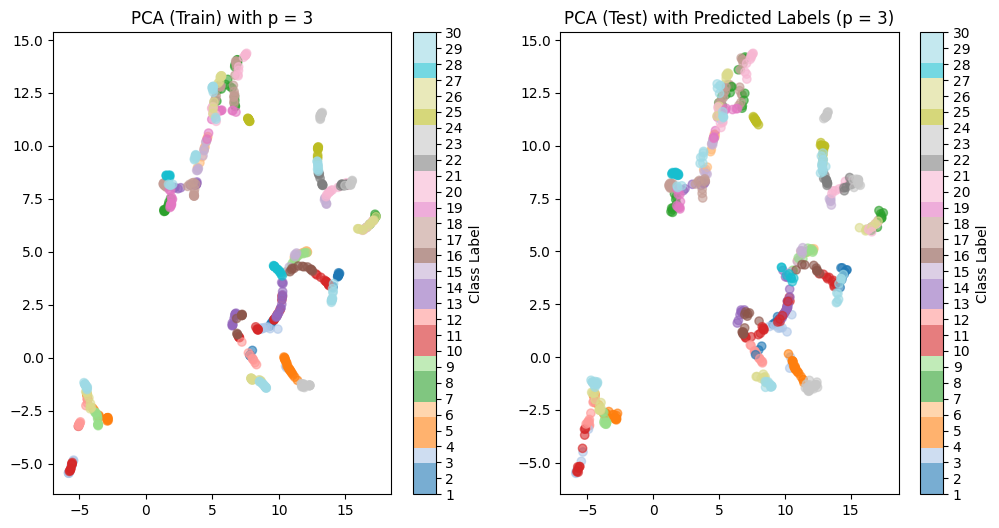

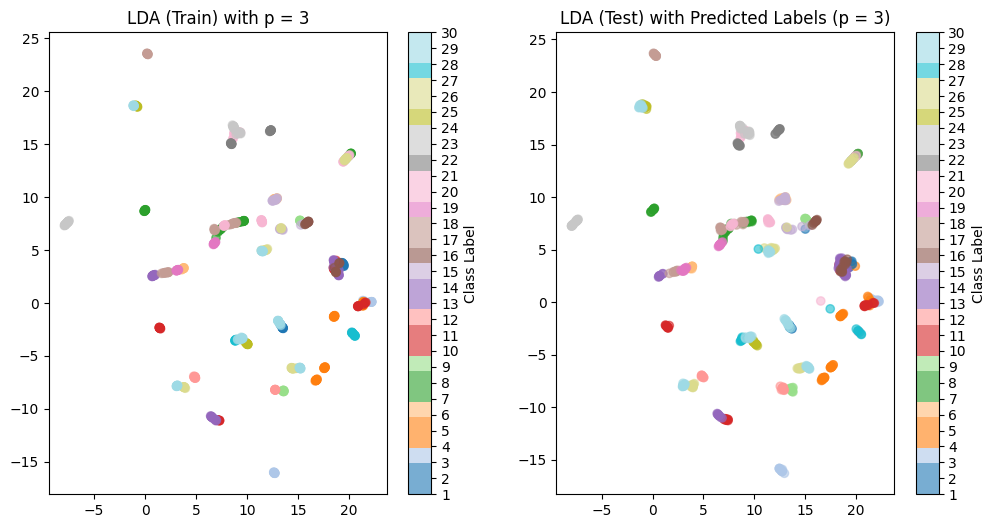

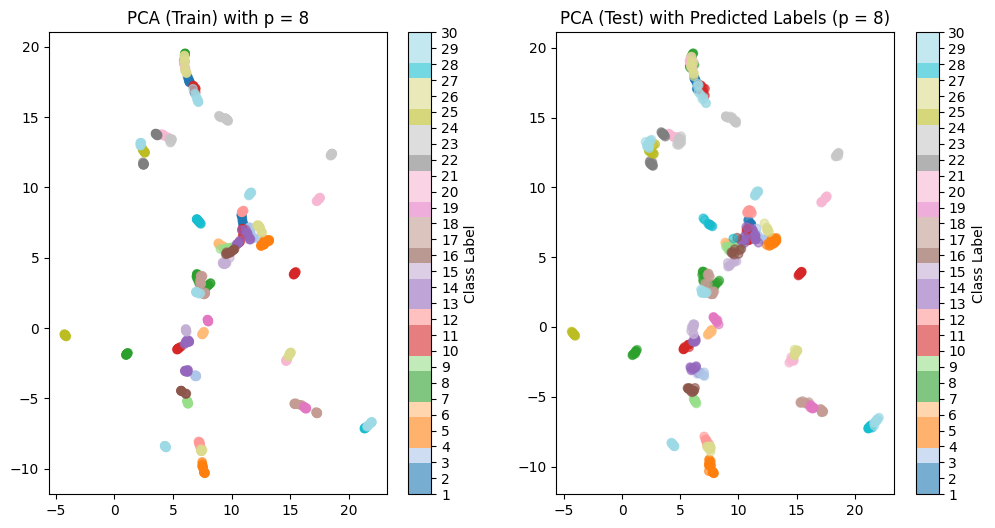

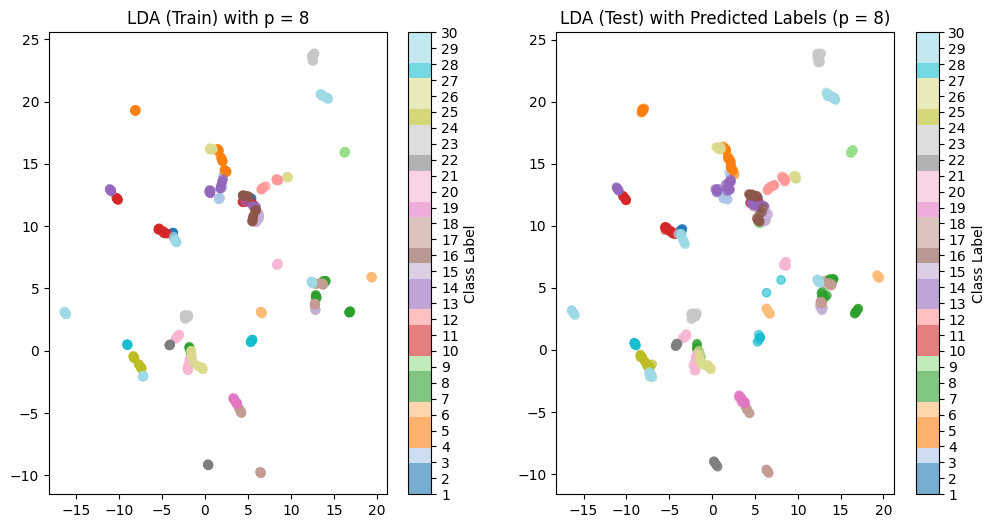

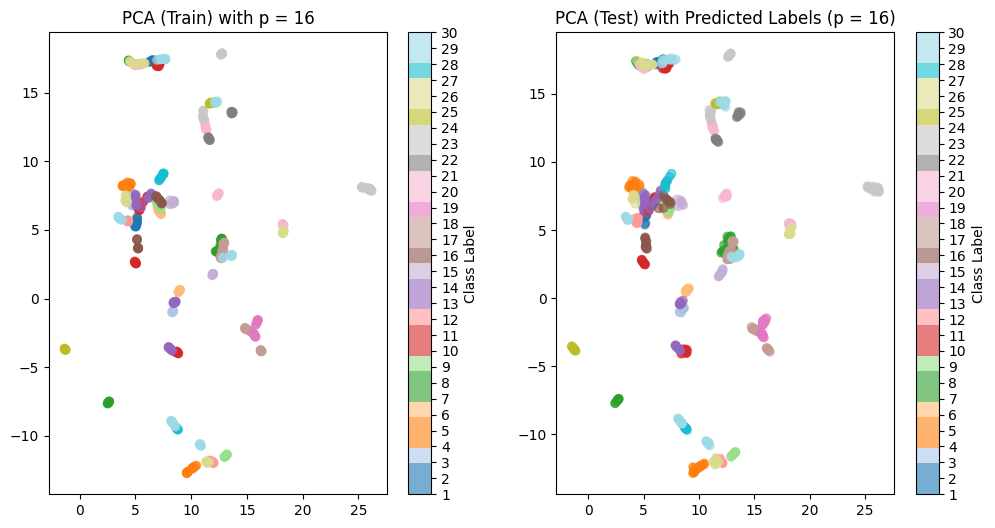

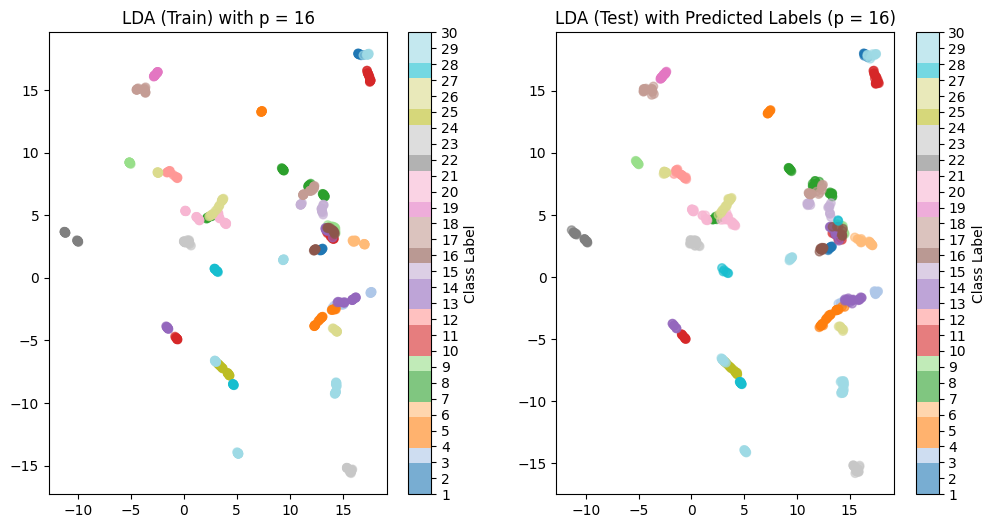

In [ ]:
dir='FaceRecognition'

x_train, y_train = read_images(dir, "train")
x_test, y_test = read_images(dir, "test")
x_train, x_test = normalize(x_train), normalize(x_test)
plot_ump_p_list=[3, 8, 16]

all_pca, all_lda, all_enc = {}, {}, {}
for p in range(1,21):
    PCA_accuracy,LDA_accuracy = classifier(x_train, x_test, y_train, y_test, p)
    all_pca[p] = PCA_accuracy
    all_lda[p] = LDA_accuracy
    print(f"Classification Accuracy: {PCA_accuracy, LDA_accuracy}%")


# plot_umap_embeddings(x_train, y_train, x_test, y_test, p, model_name=f"Model_{p}.pt")

C:\Users\aadewumi\AppData\Local\Temp\ipykernel_12352\1447134220.py:208: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(LOAD_PATH))


Accuracy for p=3: 0.9016


c:\Users\aadewumi\envece\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


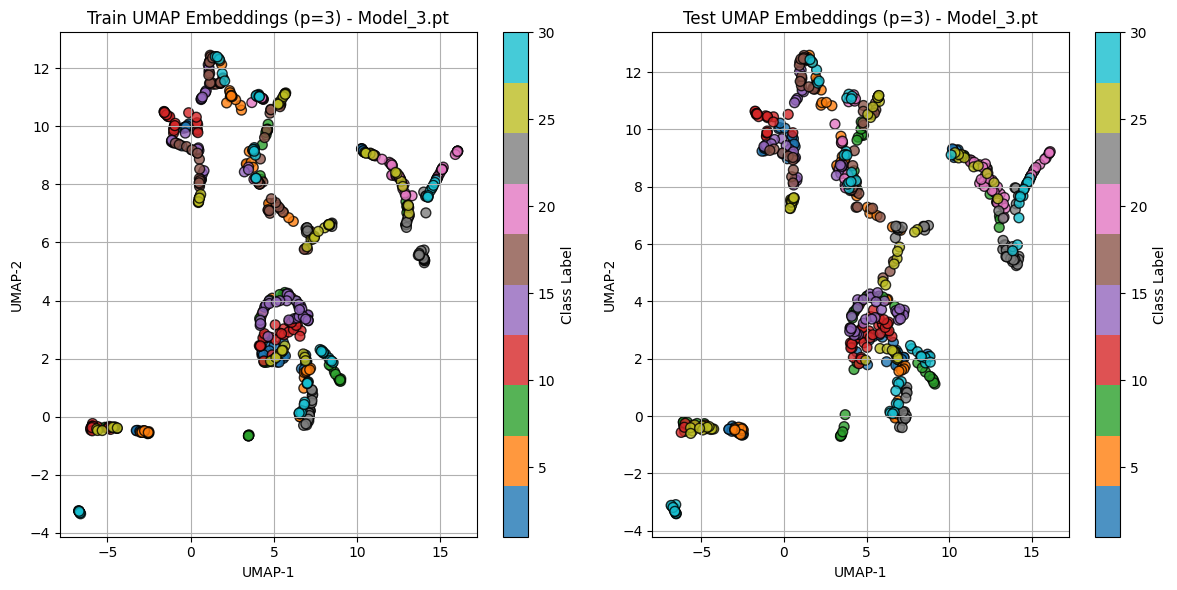

C:\Users\aadewumi\AppData\Local\Temp\ipykernel_12352\1447134220.py:208: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(LOAD_PATH))


Accuracy for p=8: 0.9905


c:\Users\aadewumi\envece\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


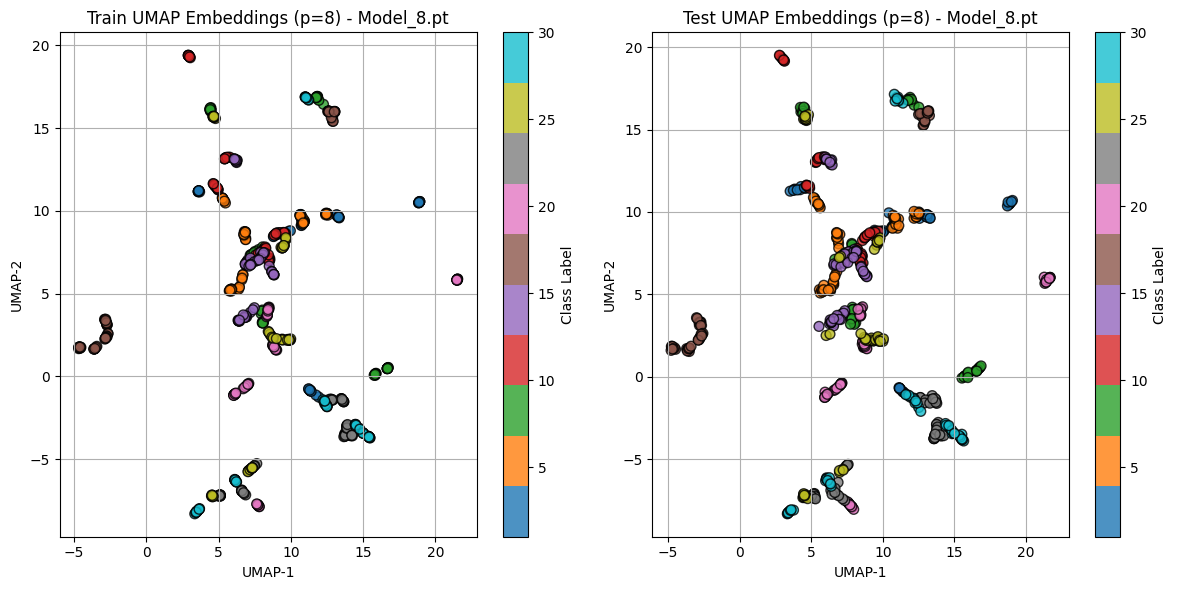

C:\Users\aadewumi\AppData\Local\Temp\ipykernel_12352\1447134220.py:208: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(LOAD_PATH))


Accuracy for p=16: 1.0000


c:\Users\aadewumi\envece\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


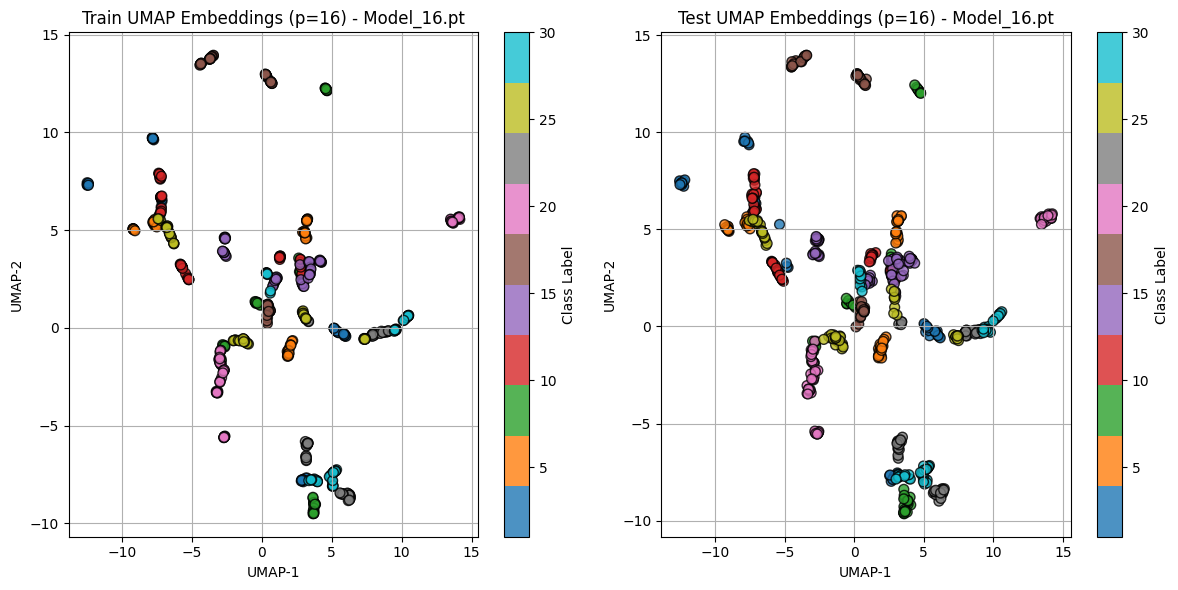

{3: 90.15873015873017, 8: 99.04761904761905, 16: 100.0} {1: 21.26984126984127, 2: 76.03174603174602, 3: 91.9047619047619, 4: 97.77777777777777, 5: 99.36507936507937, 6: 99.36507936507937, 7: 99.36507936507937, 8: 99.36507936507937, 9: 99.52380952380952, 10: 99.52380952380952, 11: 99.68253968253968, 12: 99.68253968253968, 13: 99.68253968253968, 14: 99.68253968253968, 15: 99.68253968253968, 16: 99.68253968253968, 17: 99.68253968253968, 18: 99.68253968253968, 19: 99.68253968253968, 20: 99.68253968253968} {1: 34.6031746031746, 2: 85.07936507936508, 3: 98.4126984126984, 4: 98.88888888888889, 5: 99.20634920634922, 6: 99.20634920634922, 7: 99.68253968253968, 8: 99.52380952380952, 9: 99.52380952380952, 10: 100.0, 11: 99.84126984126985, 12: 99.84126984126985, 13: 99.84126984126985, 14: 99.84126984126985, 15: 99.84126984126985, 16: 99.84126984126985, 17: 99.84126984126985, 18: 99.84126984126985, 19: 99.84126984126985, 20: 99.84126984126985}


In [9]:



class DataBuilder(Dataset):
    def __init__(self, path):
        self.path = path
        self.image_list = [f for f in os.listdir(path) if f.endswith('.png')]
        self.label_list = [int(f.split('_')[0]) for f in self.image_list]
        self.len = len(self.image_list)
        self.aug = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
        ])

    def __getitem__(self, index):
        fn = os.path.join(self.path, self.image_list[index])
        x = Image.open(fn).convert('RGB')
        x = self.aug(x)
        return {'x': x, 'y': self.label_list[index]}

    def __len__(self):
        return self.len


class Autoencoder(nn.Module):

    def __init__(self, encoded_space_dim):
        super().__init__()
        self.encoded_space_dim = encoded_space_dim
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.LeakyReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.LeakyReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(True)
        )
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(4 * 4 * 64, 128),
            nn.LeakyReLU(True),
            nn.Linear(128, encoded_space_dim * 2)
        )
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.LeakyReLU(True),
            nn.Linear(128, 4 * 4 * 64),
            nn.LeakyReLU(True)
        )
        self.unflatten = nn.Unflatten(dim=1,
                                      unflattened_size=(64, 4, 4))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(8, 3, 3, stride=2,
                               padding=1, output_padding=1)
        )

    def encode(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        mu, logvar = x[:, :self.encoded_space_dim], x[:, self.encoded_space_dim:]
        return mu, logvar

    def decode(self, z):
        x = self.decoder_lin(z)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

    @staticmethod
    def reparameterize(mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)


class VaeLoss(nn.Module):
    def __init__(self):
        super(VaeLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")

    def forward(self, xhat, x, mu, logvar):
        loss_MSE = self.mse_loss(xhat, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return loss_MSE + loss_KLD


def train(epoch):
    model.train()
    train_loss = 0

    for batch_idx, data in enumerate(trainloader):
        optimizer.zero_grad()
        mu, logvar = model.encode(data['x'])
        z = model.reparameterize(mu, logvar)
        xhat = model.decode(z)
        loss = vae_loss(xhat, data['x'], mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(trainloader.dataset)))


def plot_umap_embeddings(X_train, y_train, X_test, y_test, p, model_name):
    """
    Plots UMAP-reduced 2D embeddings for train and test data.
    
    Parameters:
        X_train: np.ndarray
            Latent space embeddings for the training data.
        y_train: np.ndarray
            Labels for the training data.
        X_test: np.ndarray
            Latent space embeddings for the testing data.
        y_test: np.ndarray
            Labels for the testing data.
        p: int
            Dimensionality of the latent space.
        model_name: str
            Identifier for the model (e.g., pretrained weight filename).
    """

    # UMAP for dimensionality reduction
    umap_model = umap.UMAP(n_components=2, random_state=42)
    train_2D = umap_model.fit_transform(X_train)
    test_2D = umap_model.transform(X_test)

    # Plot settings
    plt.figure(figsize=(12, 6))

    # Train embeddings
    plt.subplot(1, 2, 1)
    scatter_train = plt.scatter(
        train_2D[:, 0], train_2D[:, 1], c=y_train, cmap="tab10", alpha=0.8, edgecolor="k", s=50
    )
    plt.title(f"Train UMAP Embeddings (p={p}) - {model_name}")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.colorbar(scatter_train, label="Class Label")
    plt.grid(True)

    # Test embeddings
    plt.subplot(1, 2, 2)
    scatter_test = plt.scatter(
        test_2D[:, 0], test_2D[:, 1], c=y_test, cmap="tab10", alpha=0.8, edgecolor="k", s=50
    )
    plt.title(f"Test UMAP Embeddings (p={p}) - {model_name}")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.colorbar(scatter_test, label="Class Label")
    plt.grid(True)

    plt.tight_layout()
    plt.show()



##################################
# Change these
p = [3, 8, 16]
training = False
TRAIN_DATA_PATH = 'FaceRecognition/train'
EVAL_DATA_PATH = 'FaceRecognition/test'

OUT_PATH = ''


##################################
for p in p:
    LOAD_PATH = f'weights/model_{p}.pt'
    model = Autoencoder(p)

    if training:
        epochs = 100
        log_interval = 1
        trainloader = DataLoader(
            dataset=DataBuilder(TRAIN_DATA_PATH),
            batch_size=12,
            shuffle=True,
        )
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        vae_loss = VaeLoss()
        for epoch in range(1, epochs + 1):
            train(epoch)
        torch.save(model.state_dict(), os.path.join(OUT_PATH, f'model_{p}.pt'))
    else:
        trainloader = DataLoader(
            dataset=DataBuilder(TRAIN_DATA_PATH),
            batch_size=1,
        )
        model.load_state_dict(torch.load(LOAD_PATH))
        model.eval()

        X_train, y_train = [], []
        for batch_idx, data in enumerate(trainloader):
            mu, logvar = model.encode(data['x'])
            z = mu.detach().cpu().numpy().flatten()
            X_train.append(z)
            y_train.append(data['y'].item())
        X_train = np.stack(X_train)
        y_train = np.array(y_train)

        testloader = DataLoader(
            dataset=DataBuilder(EVAL_DATA_PATH),
            batch_size=1,
        )
        X_test, y_test = [], []
        for batch_idx, data in enumerate(testloader):
            mu, logvar = model.encode(data['x'])
            z = mu.detach().cpu().numpy().flatten()
            X_test.append(z)
            y_test.append(data['y'].item())
        X_test = np.stack(X_test)
        y_test = np.array(y_test)

        ##################################
        # Your code starts here
    
        
        pred_labels = np.array([one_nn(X_train.T, X_test[i, :], y_train) for i in range(X_test.shape[0])])
        accuracy = np.mean(pred_labels == y_test)
        all_enc[p]=accuracy*100
        # all_enc.append(accuracy)
        print(f"Accuracy for p={p}: {accuracy:.4f}")
        # Plot UMAP embeddings
        plot_umap_embeddings(X_train, y_train, X_test, y_test, p, model_name=f"Model_{p}.pt")

            
        ##################################

print(all_enc, all_pca, all_lda)

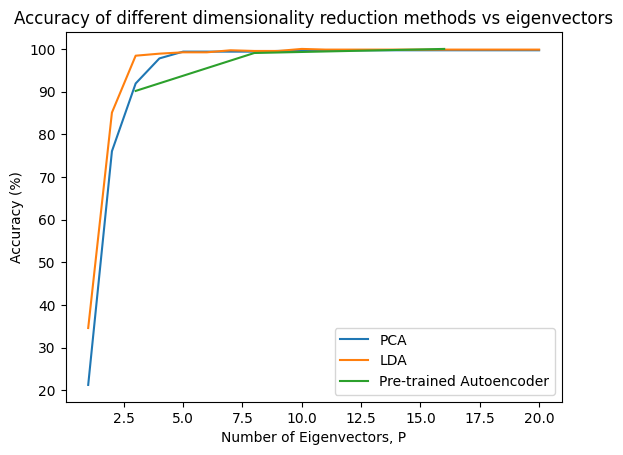

In [10]:

def plot_accuracies(dict1, dict2, dict3):


    # Extract x and y values from each dictionary
    x1, y1 = zip(*dict1.items())
    x2, y2 = zip(*dict2.items())
    x3, y3 = zip(*dict3.items())

    # Plot the data
    plt.plot(x1, y1, label='PCA')
    plt.plot(x2, y2, label='LDA')
    plt.plot(x3, y3, label='Pre-trained Autoencoder')

    # Set labels and title
    plt.xlabel('Number of Eigenvectors, P')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy of different dimensionality reduction methods vs eigenvectors')

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()
plot_accuracies(all_pca, all_lda, all_enc)

In [11]:
# Majority of the code in this section was obtained in https://engineering.purdue.edu/kak/computervision/ECE661_Fall2022/Homeworks/HW10/2BestSolutions/2.pdf
def read_images(root_dir, sub_dir):

    npz_path = os.path.join(root_dir, f"{sub_dir}.npz")
    npz_path=npz_path.replace('\\', '/')
    
    # Check if the .npz file already exists
    if not os.path.exists(npz_path):
        img_list = []
        img_path_list = glob.glob(os.path.join(root_dir, sub_dir, "*"))

        # Read each image and append to the list
        for img_path in img_path_list:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
            if img is not None:
                img_list.append(img)

        # Save the images as a compressed .npz file
        np.savez_compressed(npz_path, x=np.array(img_list))
    
    # Load images from the .npz file
    imgs = np.load(npz_path, allow_pickle=True)
    return imgs['x']

In [12]:

def integral_img(img):

    # Compute cumulative sum along both axes
    intg_img = np.cumsum(np.cumsum(img, axis=0), axis=1).astype(np.int32)
    return intg_img

def rect_sum(img, coords):
    """
    Calculates the sum of pixel values within a rectangular region using the integral image.

    Parameters:
        img (np.ndarray): Integral image.
        coords (tuple): Coordinates (r, c, off_x, off_y) specifying the rectangle.

    Returns:
        int: Rectangular sum.
    """
    r, c, off_x, off_y = coords
    
    # Fetch rectangle corners using integral image properties
    A = img[r, c]
    B = img[r, c + off_x] 
    C = img[r + off_y, c] 
    D = img[r + off_y, c + off_x] 
    
    rect_sum_value = A + D - B - C
    return rect_sum_value


def extract_features(img):
    """
    Extracts horizontal and vertical features from the integral image.
    
    Parameters:
        img (np.ndarray): Input image array.
    
    Returns:
        list: List of extracted features.
    """
    h, w = img.shape
    feats = []
    

    # Horizontal features
    for fs in range(2, w, 2):  # Filter sizes
        for i in range(h - 1):
            for j in range(w - fs):
                coord_b = (i, j, fs // 2, 1)
                coord_w = (i, j + fs // 2, fs // 2, 1)
                
                b_sum = rect_sum(img, coord_b)
                w_sum = rect_sum(img, coord_w)
                feat_val = w_sum - b_sum
                feats.append(feat_val)

    # Vertical features
    for fs in range(2, h, 2):  # Filter sizes
        for j in range(w - 1):
            for i in range(h - fs):
                coord_b = (i, j, 1, fs // 2)
                coord_w = (i + fs // 2, j, 1, fs // 2)
                
                b_sum = rect_sum(img, coord_b)
                w_sum = rect_sum(img, coord_w)
                feat_val = w_sum - b_sum
                feats.append(feat_val)

    return feats


In [13]:

def calc_feat_mat(imgs, name):

    file_path = f'{name}.npz'

    # If the feature matrix file exists, load and return it
    if not os.path.exists(file_path):
        feat_mat = []
        for im in imgs:
            int_img = integral_img(im)  # Compute the integral image
            feat_vec = extract_features(int_img)  # Extract features
            feat_mat.append(feat_vec)
    
        # Save the feature matrix in compressed format
        feat_mat_np = np.array(feat_mat)
        np.savez_compressed(file_path, x=np.transpose(feat_mat_np))


    arr = np.load(file_path, allow_pickle=True)
    return arr['x']




In [14]:

# Construct weak classifier
def weak_classifier(weight, feats, labels):
    least_err = np.inf  # Initialize least error as infinity
    weight = weight / np.sum(weight)  # Normalize weights

    # Calculate total positive and negative weights
    # print(weight[labels == 1])
    # print(np.sum(weight[np.where(labels == 1)]))
    Tp = np.sum(weight[labels == 1])  # Total weight of positive samples
    Tn = np.sum(weight[labels == 0])  # Total weight of negative samples

    # Sort each feature in ascending order
    idx = np.argsort(feats, axis=1)
    sorted_feats = np.take_along_axis(feats, idx, axis=1)
    sorted_weight = np.take_along_axis(weight[np.newaxis, :], idx, axis=1)
    sorted_labels = np.take_along_axis(labels[np.newaxis, :], idx, axis=1)

    # Calculate cumulative sums for positive and negative weights
    Sp = np.cumsum(sorted_weight * sorted_labels, axis=1)
    Sn = np.cumsum(sorted_weight, axis=1) - Sp

    # Calculate errors for both polarities
    err1 = Sp + (Tn - Sn)  # Positive polarity error
    err2 = Sn + (Tp - Sp)  # Negative polarity error

    best_weak_cl = None
    f_pred = None

    # Iterate through all features to find the one with the least error
    for i, (feat, s_feat, e1, e2) in enumerate(zip(feats, sorted_feats, err1, err2)):
        min_err = np.minimum(e1, e2)  # Take the minimum error at each threshold
        min_err_idx = np.argmin(min_err)  # Index of minimum error

        # Determine polarity and error based on the minimum error
        if e1[min_err_idx] <= e2[min_err_idx]:
            pol = 1
            pred = (feat >= s_feat[min_err_idx]).astype(np.uint8)
            e = e1[min_err_idx]
        else:
            pol = -1
            pred = (feat < s_feat[min_err_idx]).astype(np.uint8)
            e = e2[min_err_idx]

        # Store parameters for the current classifier
        c_params = [i, s_feat[min_err_idx], pol, e]

        # Update best classifier if it has the least error
        if min_err[min_err_idx] < least_err:
            best_weak_cl = c_params
            f_pred = pred
            least_err = min_err[min_err_idx]

    return best_weak_cl, f_pred


In [15]:
def cascade(tr_pos_feat, tr_neg_feat, pos_lbls, neg_lbls, req_tpr, req_fpr, max_num_wcl):
    """
    Cascades multiple weak classifiers to create a strong classifier.
    """
    cl_list = []
    alpha_list = []
    pred_list = []
    tpr, fpr, tnr, fnr, rep_fpr = 0, 0, 0, 0, 0

    num_p = tr_pos_feat.shape[1]
    num_n = tr_neg_feat.shape[1]

    # Initialize weights
    weights = np.concatenate(
        (np.ones(num_p) * 0.5 / num_p, np.ones(num_n) * 0.5 / num_n)
    )

    # Combine features and labels
    feats = np.hstack((tr_pos_feat, tr_neg_feat))
    labels = np.hstack((pos_lbls, neg_lbls))

    for n in range(max_num_wcl):
        best_weak_cl, f_pred = weak_classifier(weights, feats, labels)
        cl_list.append(best_weak_cl)

        # Update alpha
        eps = best_weak_cl[-1]
        beta = eps / (1 - eps + 1e-6)
        alpha = np.log(1 / beta + 1e-6)
        alpha_list.append(alpha)

        # Update weights
        weights = weights * np.power(beta, 1 - np.abs(labels - f_pred))

        # Compute cascade output
        pred_list.append(f_pred)
        feat_arr = np.transpose(np.array(pred_list))
        alpha_arr = np.transpose(np.array([alpha_list]))
        cascade_output = np.dot(feat_arr, alpha_arr)

        # Threshold cascade output
        thresh = np.min(cascade_output[:num_p])
        Cx = np.zeros_like(cascade_output)
        Cx[cascade_output >= thresh] = 1

        # Calculate true/false positive rates and repeated false positive rate
        tpr = np.sum(Cx[:num_p]) / num_p
        fpr = np.sum(Cx[num_p:]) / num_n
        tnr=1-fpr
        fnr=1-tpr
        rep_fpr = np.sum(Cx[num_p:]) / 1758  # Assuming 1758 is the total number of negatives

        if tpr >= req_tpr and fpr <= req_fpr:
            print(f"Classifier completed at stage {n + 1}")
            break

    # Metrics and removal of misclassified negatives
    metrics = np.array([tpr, rep_fpr, tnr, fnr])
    # neg_preds = Cx[num_p:]
    neg_ids = neg_ids = np.where(Cx[num_p:] == 1)[0]
    refined_neg_feats = tr_neg_feat[:, neg_ids]
    new_neg_labels = np.zeros(len(neg_ids))

    print(f"False Positives in stage = {len(neg_ids)}")

    return refined_neg_feats, new_neg_labels, cl_list, alpha_list, metrics


In [16]:
root_dir='CarDetection'
train_pos,train_neg = read_images(root_dir, 'train/positive'), read_images(root_dir, 'train/negative')
test_pos, test_neg = read_images(root_dir, 'test/positive'), read_images(root_dir, 'test/negative')



# Initialize labels for training and testing data
tr_neg_lbl = np.zeros((train_neg.shape[0]))
tr_pos_lbl = np.ones((train_pos.shape[0]))


# Calculate features and save to files if not already saved
tr_pos_ft = calc_feat_mat(train_pos, 'train_pos')
tr_neg_ft = calc_feat_mat(train_neg, 'train_neg')
te_pos_ft = calc_feat_mat(test_pos, 'test_pos')
te_neg_ft = calc_feat_mat(test_neg, 'test_neg')

# Training: Create cascade classifier
if not os.path.exists('stage_cl_al.npz'):
    max_stages = 10
    stage_cl_list = []
    stage_alpha_list = []
    tr_fpr_arr = []

    for stage in range(max_stages):
        tr_neg_ft, tr_neg_lbl, cl_list, alpha_list, metrics = cascade(
            tr_pos_ft, tr_neg_ft, tr_pos_lbl, tr_neg_lbl, 1, 0.45, 50
        )
        
        _, fpr, _, _ = metrics
        stage_cl_list.append(cl_list)
        stage_alpha_list.append(alpha_list)
        tr_fpr_arr.append(fpr)

        # Stop training if no more negative samples
        if tr_neg_ft.shape[1] == 0:
            print(f"Training stopped at stage: {stage + 1}")
            break

    # Save classifiers and alphas
    np.savez_compressed(
        'stage_cl_al',
        x=np.array(stage_cl_list, dtype=object),
        y=np.array(stage_alpha_list, dtype=object)
    )
    print('FPR rate',tr_fpr_arr)

# Load saved cascade
data = np.load('stage_cl_al.npz', allow_pickle=True)
print("stage_cl_al loaded")

stage_cl = data['x']
stage_al = data['y']

# Testing: Combine positive and negative test features
test_feats = np.hstack((te_pos_ft, te_neg_ft))
wt_mul = 0.5

pred_arr = []

# Iterate through classifiers for each stage
for cls, als in zip(stage_cl, stage_al):
    wpred_arr = []

    # Iterate through each weak classifier
    for cl in cls:
        i, thresh, pol, _ = cl  # Unpack classifier parameters
        current_feat = test_feats[int(i)]  # Select feature
        test_pred = current_feat >= thresh if pol == 1 else current_feat <= thresh
        wpred_arr.append(test_pred.astype(np.uint8))

    # Convert weak predictions to array
    wpred_arr = np.transpose(np.array(wpred_arr))

    # Cascade output
    c_out = np.dot(wpred_arr, als)
    thr = np.sum(als) * wt_mul
    cx = np.zeros_like(c_out)
    cx[c_out >= thr] = 1
    pred_arr.append(cx)

pred_arr = np.array(pred_arr)

# Evaluate predictions
test_numP = test_pos.shape[0]
test_numN = test_neg.shape[0]

te_fpr_list = []
te_fnr_list = []

for i in range(pred_arr.shape[0]):
    ps = pred_arr[0].copy()
    for j in range(i + 1):
        ps = np.logical_and(ps, pred_arr[j])

    ref_pred = ps
    te_fpr_list.append(np.sum(ref_pred[test_numP:]) / test_numN)
    te_fnr_list.append(1 - np.sum(ref_pred[:test_numP]) / test_numP)

print('FPR ',te_fpr_list)
print('FNR ',te_fnr_list)


stage_cl_al loaded
FPR  [0.08636363636363636, 0.022727272727272728, 0.013636363636363636, 0.006818181818181818, 0.004545454545454545, 0.004545454545454545, 0.004545454545454545, 0.004545454545454545]
FNR  [0.1292134831460674, 0.1966292134831461, 0.2247191011235955, 0.2471910112359551, 0.2752808988764045, 0.3202247191011236, 0.3258426966292135, 0.3314606741573034]


In [17]:

x_values = range(1, len(tr_fpr_arr)+1)

# Create a plot
plt.plot(x_values, tr_fpr_arr)

# Add labels and title
plt.xlabel('Stages')
plt.ylabel('Rates')
plt.title('FPR during training vs stages')

# Show the plot
plt.show()


plt.figure(figsize=(10, 6))

# Plot the first list
plt.plot(range(1, len(te_fpr_list) + 1), te_fpr_list, label='FPR')  # Start x-axis from 1

# Plot the second list
plt.plot(range(1, len(te_fnr_list) + 1), te_fnr_list, label='FNR')  # Start x-axis from 1

# Set labels and title
plt.xlabel('Stages')
plt.ylabel('Rates')
plt.title('FPR and FNR during testing vs stages')

# Add legend
plt.legend()

# Adjust x-axis ticks
plt.xticks(range(1, len(te_fpr_list) + 1))  # Set ticks starting from 1

# Show the plot
plt.show()


NameError: name 'tr_fpr_arr' is not defined